In [1]:
%matplotlib inline

import os, pathlib
import logging, warnings
logging.basicConfig(level=logging.ERROR)
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"

finally:
    os.chdir(nbPath)

FIGPATH = params.figPath / 'figS2-TME'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

### get data

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList_CO[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [3]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [4]:
full_list_MCx, allDFs_MCx = get_full_monkey_data()
allDFs_M1, allDFs_Str = get_full_mouse_data()


Executed: `get_full_monkey_data` in 12.9s
Executed: `get_full_mouse_data` in 0.7s


### Fig S2A&B: TME for monkey center-out

#### Get data

In [5]:
defs = monkey_defs
full_list_MCx = []
for animal, sessionList in GoodDataList_CO[defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root/animal/session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))


warnings.filterwarnings("default")


pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')

side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]

session = defs.raster_example[1]
ExSession = defs.prep_general(dt.load_pyal_data(root / session.split('_')[0] / session))

len(pairFileList1)=126


/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/smoothing.py:27: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  win = scs.gaussian(int(10*std/bin_length), std/bin_length)


#### Fig S2A: TME example session
Comparing the `cov` matrix of the real and surrogate data

In [6]:
def get_neural_and_TME_data(data_list: pd.DataFrame, epoch: Callable =None , area: str ='M1') -> np.ndarray:
    """
    similar to `get_data_array` to get the neural data of a singgle session
    """
    assert isinstance(data_list, pd.DataFrame)
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list.target_id)
    for target in target_ids:
        df_ = pyal.select_trials(data_list, data_list.target_id== target)
        n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    if epoch is not None:
        df_ = pyal.restrict_to_interval(data_list,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(target_ids), n_shared_trial, n_timepoints, data_list[field][0].shape[1]))

    rng = params.rng
    df_ = pyal.restrict_to_interval(data_list, epoch_fun=epoch) if epoch is not None else df

    for targetIdx,target in enumerate(target_ids):
        df__ = pyal.select_trials(df_, df_.target_id==target)
        all_id = df__.trial_id.to_numpy()
        # to guarantee shuffled ids
        while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
            continue
        all_id = all_id_sh
        # select the right number of trials to each target
        df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
        for trial, trial_rates in enumerate(df__[field]):
            AllData[targetIdx,trial, :, :] = trial_rates

    try:
        matlab.engine
        print('Matlab engine already running!')
    except NameError:
        import matlab.engine
        eng = matlab.engine.start_matlab()
        eng.cd(r'../tools/TME/', nargout=0)
        eng.addpath(eng.pwd()+'/util', eng.pwd()+'/genTME')

    rates = np.transpose(AllData.reshape(AllData.shape[0], -1, AllData.shape[-1]),(1, 2, 0))  # time x neuron x target
    rates = np.require(rates, dtype=np.float32, requirements=['A', 'O', 'W', 'C'])
    # Use the surrogate data generated with TME
    TME_rates = eng.computeTME(rates,'surrogate-TNC')
    TME_rates = np.array(TME_rates)

    return AllData, TME_rates

def return_cov(data):
    try:
        matlab.engine
        print('Matlab engine already running!')
    except NameError:
        import matlab.engine
        eng = matlab.engine.start_matlab()
        eng.cd(r'../tools/TME/', nargout=0)
        eng.addpath(eng.pwd()+'/util', eng.pwd()+'/genTME')

    flags = ('T', 'C', 'N')
    sigma = {}
    for flag in flags:
        sigma[flag] = np.array(eng.marginalCov(data, flag))
    
    return sigma

both _real_ and _surr_ rates defined below are in shape: $time \times neuron \times target$

In [7]:
real_rates, surr_rates = get_neural_and_TME_data (ExSession, defs.exec_epoch, area=defs.areas[2])
real_rates = np.transpose(real_rates.reshape(real_rates.shape[0], -1, real_rates.shape[-1]),(1, 2, 0))
real_rates = np.require(real_rates, dtype=np.float32, requirements=['A', 'O', 'W', 'C'])
surr_rates = np.require(surr_rates, dtype=np.float32, requirements=['A', 'O', 'W', 'C'])
print(f'{surr_rates.shape=}')

surr_covs = return_cov(surr_rates)
real_covs = return_cov(real_rates)


surr_rates.shape=(315, 109, 8)


Time covariance


/home/jcc319/anaconda3/envs/cca2/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


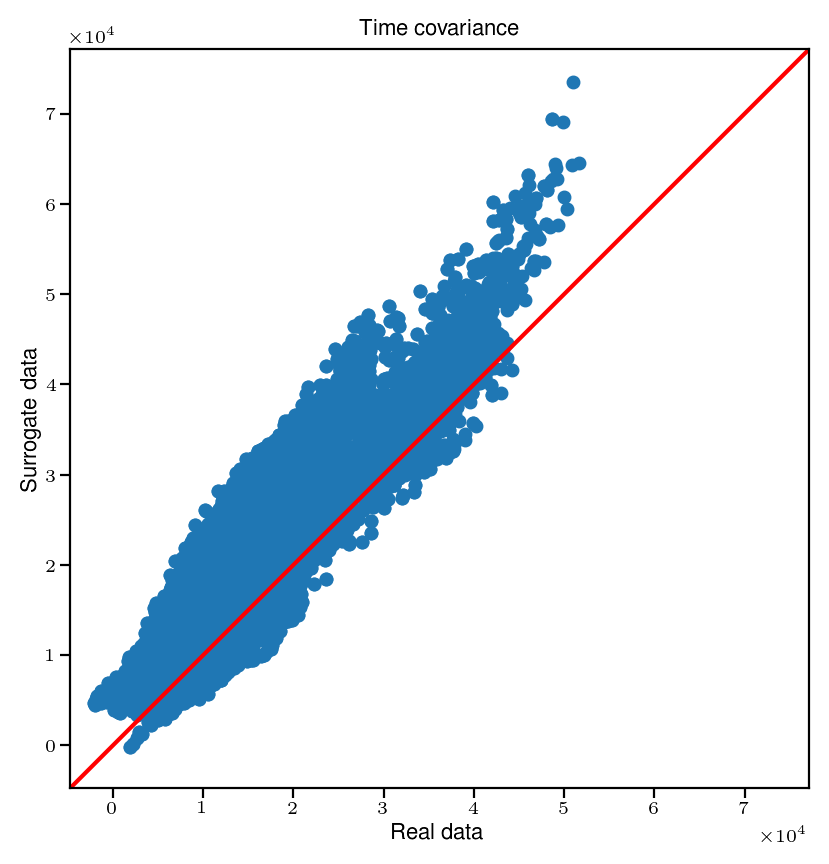

In [8]:
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(real_covs['T'].flatten(),surr_covs['T'].flatten())
ax.axline([0, 0], [1, 1], color='r')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_ylim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_aspect('equal')

ax.set_xlabel('Real data')
ax.set_ylabel('Surrogate data')
ax.set_title('Time covariance')
ax.ticklabel_format(style='scientific', scilimits=(4,4), useMathText=True)

fig.savefig(FIGPATH / 'TME-time-cov.pdf', format='pdf', bbox_inches='tight')

target covariance

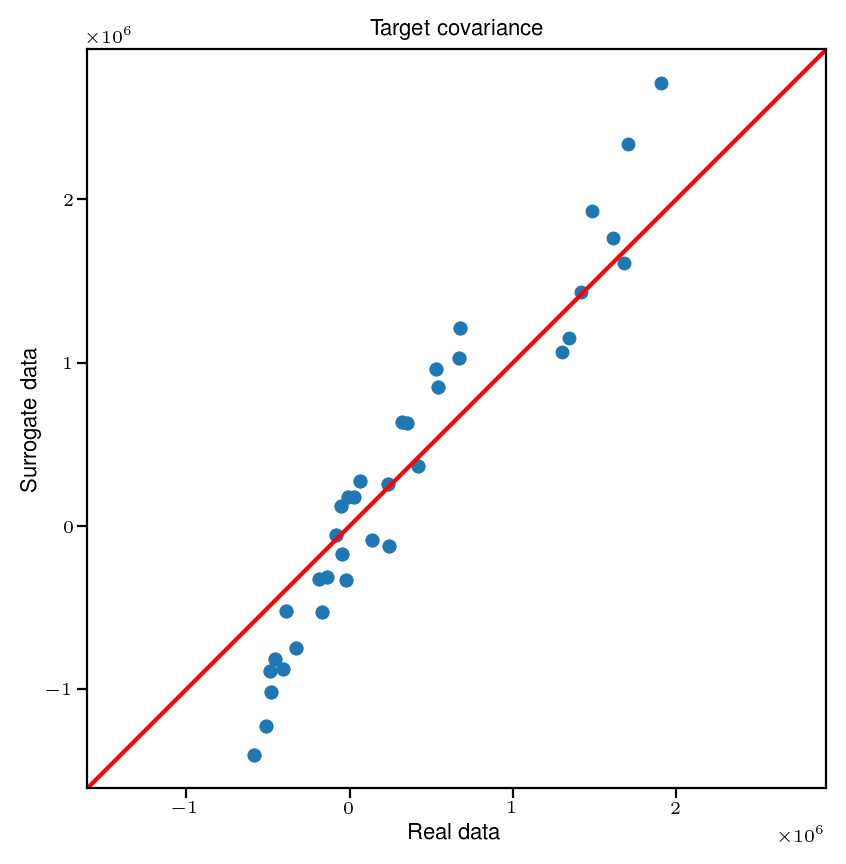

In [9]:
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(real_covs['C'].flatten(),surr_covs['C'].flatten())
ax.axline([0, 0], [1, 1], color='r')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_ylim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_aspect('equal')

ax.set_ylabel('Surrogate data')
ax.set_xlabel('Real data')
ax.set_title('Target covariance')
ax.ticklabel_format(style='scientific', scilimits=(6,6), useMathText=True)

fig.savefig(FIGPATH / 'TME-target-cov.pdf', format='pdf', bbox_inches='tight')

neuronal covariance

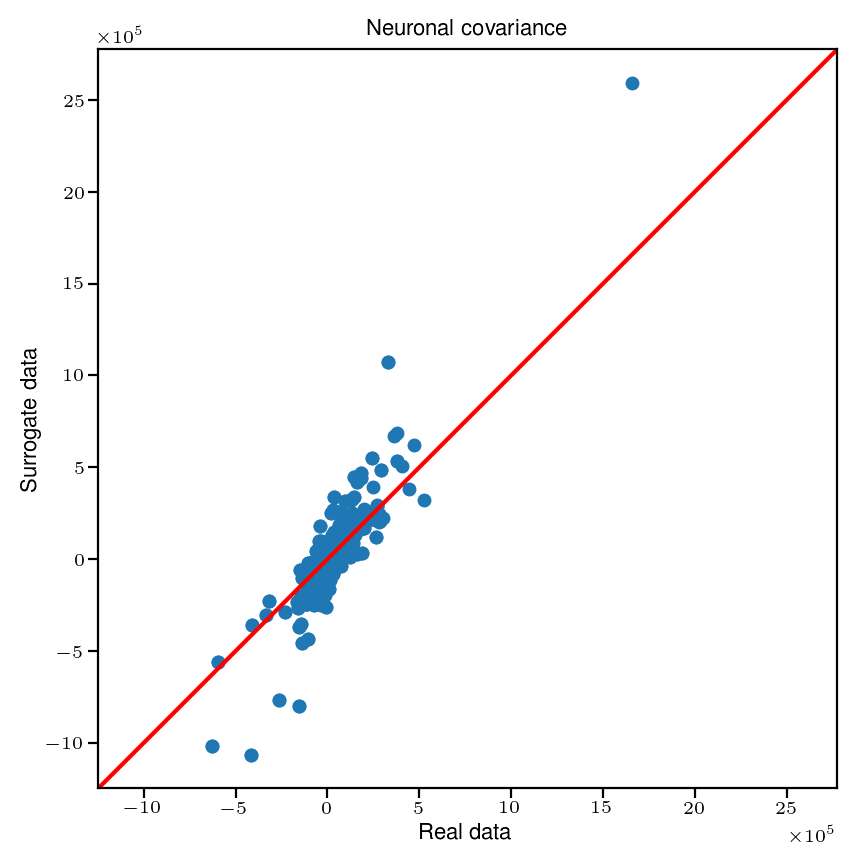

In [10]:
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(real_covs['N'].flatten(), surr_covs['N'].flatten())
ax.axline([0, 0], [1, 1], color='r')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_ylim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_aspect('equal')

ax.set_ylabel('Surrogate data')
ax.set_xlabel('Real data')
ax.set_title('Neuronal covariance')
ax.ticklabel_format(style='scientific', scilimits=(5,5), useMathText=True)

fig.savefig(FIGPATH / 'TME-N-cov.pdf', format='pdf', bbox_inches='tight')


#### Fig S2B: TME alignment

modified `get_data_array` function for __TME__

In [11]:
def get_TME_array(data_list: list[pd.DataFrame], epoch: Callable =None , area: str ='M1', model: Callable =None, n_components:int = 10) -> np.ndarray:
    """
    Applies the `model` to the `data_list` and return a data matrix of the shape: sessions x targets x trials x time x modes
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyalData (could also be a single dataset)
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun()`
    `area`: area, either: 'M1', or 'S1', or 'PMd', ...
    `model`: a model that implements `.fit()`, `.transform()` and `n_components`. By default: `PCA(10)`. If it's an integer: `PCA(integer)`.
    `n_components`: use `model`, this is for backward compatibility
    
    Returns
    -------
    `AllData`: np.ndarray

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', model=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    try:
        matlab.engine
        print('Matlab engine already running!')
    except NameError:
        import matlab.engine
        eng = matlab.engine.start_matlab()
        eng.cd(r'../tools/TME/', nargout=0)
        eng.addpath(eng.pwd()+'/util', eng.pwd()+'/genTME')

    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    if model is None:
        model = PCA(n_components=n_components, svd_solver='full')
    elif isinstance(model, int):
        model = PCA(n_components=model, svd_solver='full')
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list[0].target_id)
    for df in data_list:
        for target in target_ids:
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    if epoch is not None:
        df_ = pyal.restrict_to_interval(data_list[0],epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), len(target_ids), n_shared_trial, n_timepoints, model.n_components))
    AllRates = []
    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
        rates = []
        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            rates.append(np.concatenate(df__[field].values, axis=0))
        
        rates = np.stack(rates, axis=2)  # rates: time x neuron x target
        # Use the surrogate data generated with TME
        rates = eng.computeTME(rates,'surrogate-TNC')
        rates = np.array(rates)
        AllRates.append(rates)
        rates_ = np.reshape(rates, (-1,rates.shape[1]))
        rates_model = model.fit(rates_)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');
        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # to guarantee shuffled ids
            while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
                continue
            all_id = all_id_sh
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__._pca):
                AllData[session,targetIdx,trial, :, :] = trial_rates

    return AllData, AllRates


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=15
min_time=15


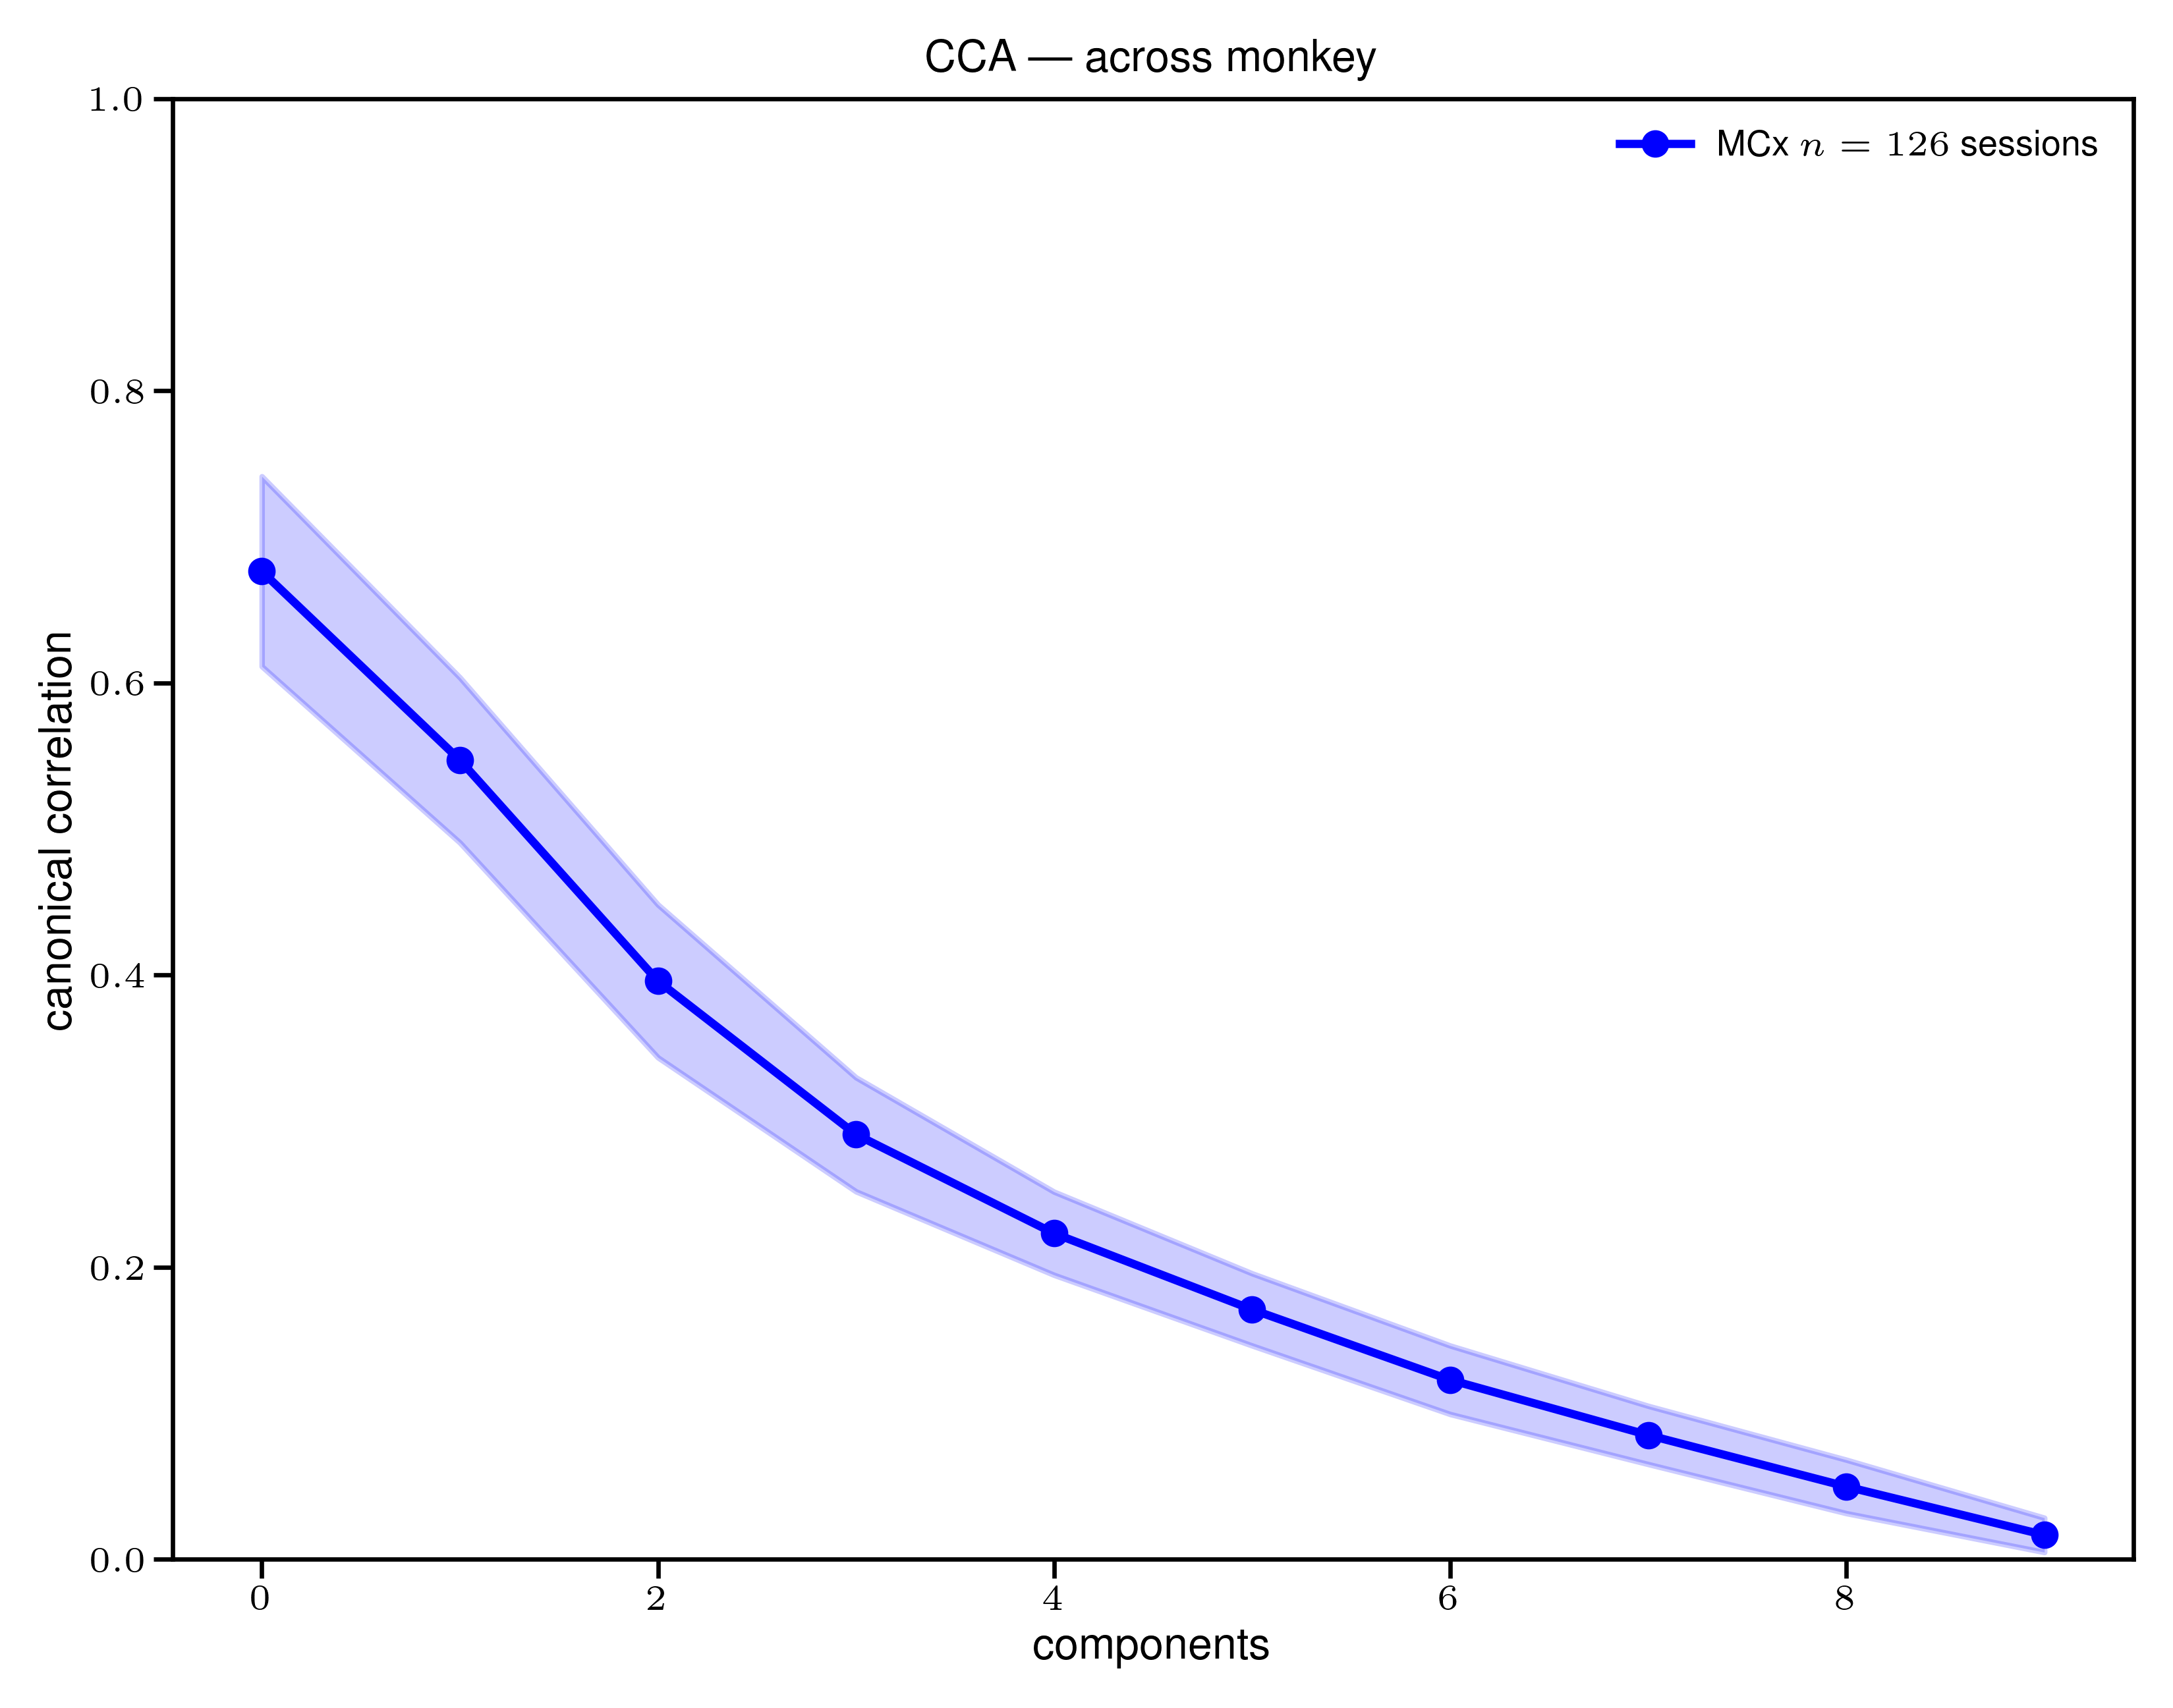

In [12]:
warnings.filterwarnings("ignore")
AllData1, SurrData1 = get_TME_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2, SurrData2 = get_TME_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

# plot
set_rc()
fig,ax = plt.subplots()
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[2]} $n={allCCs0.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

fig.savefig(FIGPATH / 'TME-CCA.pdf', format='pdf', bbox_inches='tight')

### Fig S2C: TME for mouse

#### get data

In [14]:
defs = mouse_defs

animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [15]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)
warnings.filterwarnings("default")


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))

print(f'{len(pairFileList2)=}')


len(pairFileList1)=13
len(pairFileList2)=13


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=22
min_time=15


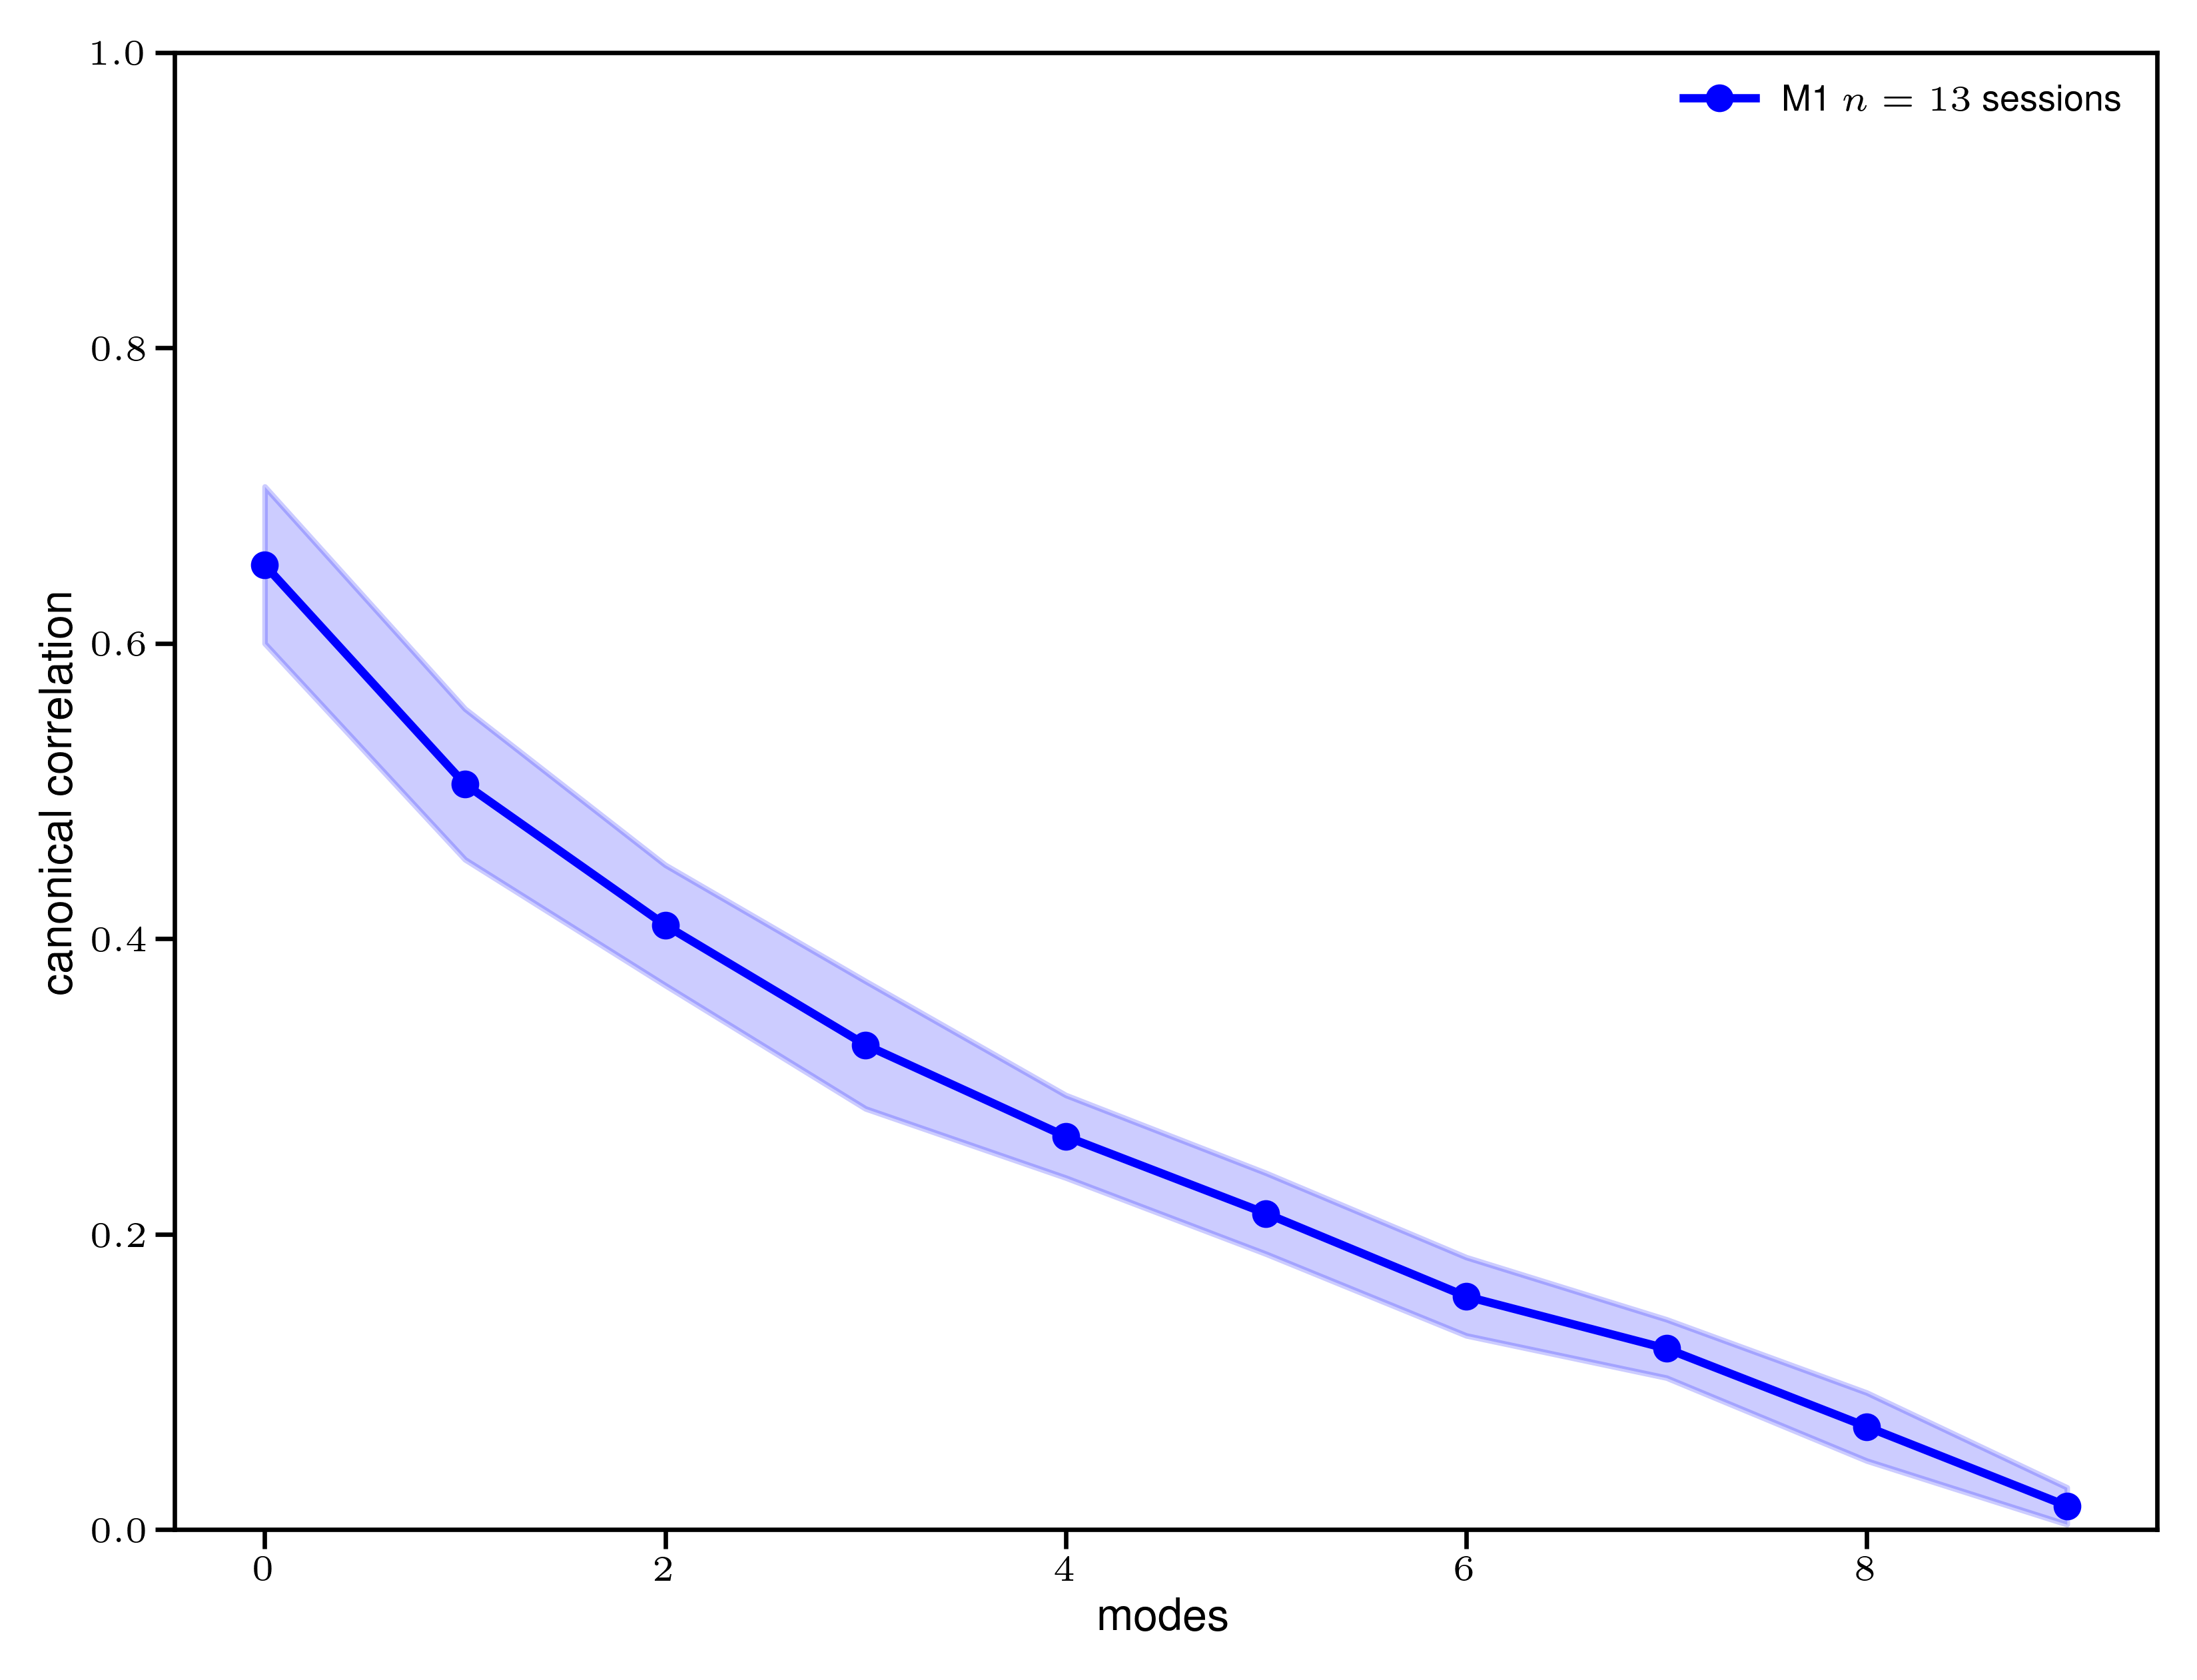

In [16]:
side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1, SurrData1 = get_TME_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
AllData2, SurrData2 = get_TME_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

# plot
set_rc()
fig,ax = plt.subplots()

utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[0]} $n={allCCs0.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('modes')
ax.legend()
ax.set_ylabel('canonical correlation')

fig.savefig(FIGPATH / 'mouse-TME-CCA.pdf', format='pdf', bbox_inches='tight')

### Fig S2D: TME for monkey random walk

#### get data

In [ ]:
try:
    os.chdir(RepoPath / 'random_walk')
    %run "_dataset-selection.ipynb"
finally:
    os.chdir(NBPath)

### Fig S2E: VAF of CCs vs PCs

In [17]:
from scipy.linalg import inv
try:
    matlab.engine
    print('Matlab engine already running!')
except NameError:
    import matlab.engine
    eng = matlab.engine.start_matlab()
dpcaPath = str(params.repoPath) + '/tools/dPCA/'
eng.cd(dpcaPath, nargout=0)
        
def vaf_pca_cca(df1:pd.DataFrame, field1: str, epoch1,
               df2:pd.DataFrame, field2: str, epoch2,
               n_components:int =10) -> (np.ndarray, np.ndarray):
    """
    Measure vaf for each CCA axis, between 2 DataFrames, fields, time epochs.
    epoch1, epoch2: an instance of the `pyal.generate_epoch_fun` function.
    """
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');
    pca_1_data = np.concatenate(df1['_pca'].values, axis=0)

    
    df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
    rates_2 = np.concatenate(df2[field2].values, axis=0)
    rates_2_model = PCA(n_components=n_components, svd_solver='full').fit(rates_2)
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');
    pca_2_data = np.concatenate(df2['_pca'].values, axis=0)
    
    
    # same number of timepoints in both matrices
    n_samples = min ([pca_1_data.shape[0], pca_2_data.shape[0]])
    pca_1_data = pca_1_data[:n_samples,:]
    pca_2_data = pca_2_data[:n_samples,:]

    A, B, *_ = dt.canoncorr(pca_1_data, pca_2_data, fullReturn=True)
    vafs_cc1 = np.array(vaf_cc(rates_1, rates_1_C, A))[0]/100
    vafs_cc2 = np.array(vaf_cc(rates_2, rates_2_C, B))[0]/100

    vafs_pc1 = np.cumsum(rates_1_model.explained_variance_ratio_)
    vafs_pc2 = np.cumsum(rates_2_model.explained_variance_ratio_)
    
    return vafs_cc1, vafs_cc2, vafs_pc1, vafs_pc2

def vaf_cc(X, C, A):
    W = C.T@A #neural -> CCs
    V = W@inv(A.T@A) #neural -> CCs 
    vaf = eng.dpca_explainedVariance(X.T, W, V)['cumulativeDPCA']
    return vaf

@utility.report
def plot_monkey_vaf_cca(ax, full_list_MCx, allDFs_MCx, top_n: int=10):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    field = monkey_defs.areas[2]+'_rates'
    vafs_cc1 = []
    vafs_cc2 = []
    vafs_pc1 = []
    vafs_pc2 = []
    vafs = []
    for df1,df2 in zip(side1df,side2df):
        vafs_cc1_, vafs_cc2_, vafs_pc1_, vafs_pc2_ = vaf_pca_cca(
            df1, field, monkey_defs.exec_epoch, 
            df2, field, monkey_defs.exec_epoch)

        vafs_cc1.append(vafs_cc1_[top_n-1])
        vafs_cc2.append(vafs_cc2_[top_n-1])
        vafs_pc1.append(vafs_pc1_[top_n-1])
        vafs_pc2.append(vafs_pc2_[top_n-1])

        vafs.append(np.mean([vafs_cc1_, vafs_cc2_], axis = 0).flatten())

    vafs_cc1 = np.array(vafs_cc1)
    vafs_cc2 = np.array(vafs_cc2)
    vafs_pc1 = np.array(vafs_pc1)
    vafs_pc2 = np.array(vafs_pc2)

    ax.scatter(vafs_cc1, vafs_pc1, c = 'k')
    ax.scatter(vafs_cc2, vafs_pc2, c = 'k')
    ax.set_xlabel("VAF CCs")
    ax.set_ylabel("VAF PCs")
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    
    return vafs
        

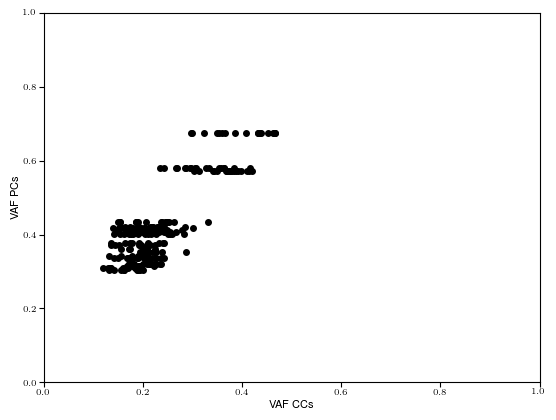

In [18]:
fig,ax = plt.subplots(dpi=100)
vafs = plot_monkey_vaf_cca(ax,full_list_MCx, allDFs_MCx, top_n=4)
plt.savefig(FIGPATH / 'vaf_cca_monkeys.pdf', format= 'pdf')
clear_output()


### Fig S2F: CCA based on manifold dimensionality

In [19]:
@utility.report
def plot_monkey_cca_dim(ax, full_list_MCx, allDFs_MCx):
    dim_range = range(2,20)

    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
        CCs= []
        for sessionData1, sessionData2 in zip(AllData1, AllData2):
            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
            data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
            CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs [:,i]=CCs 

    # plotting
    x_ = list(dim_range)
    utility.shaded_errorbar(ax, x_, allCCs.T, color=params.colors.MonkeyPts, marker = 'o', label='Monkeys')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs

@utility.report
def plot_monkey_cca_dim_prep(ax, full_list_MCx, allDFs_MCx):
    dim_range = range(2,20)

    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            if 'J' in animal1 or 'J' in animal2: continue
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        AllData2 = dt.get_data_array(side2df, monkey_defs.prep_epoch,
                                     area=monkey_defs.areas[2], model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
        CCs= []
        for sessionData1, sessionData2 in zip(AllData1, AllData2):
            data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
            data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
            CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs [:,i]=CCs 

    # plotting
    x_ = list(dim_range)
    utility.shaded_errorbar(ax, x_, allCCs.T, color='tab:green', marker = 'o', label='Monkeys (prep)')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs



In [20]:
@utility.report
def plot_mouse_cca_dim(ax, allDFs_M1, area = 'M1'):
    dim_range = range(2,20)

    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]

    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=area, model=n_comp)
        AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=area, model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape), axis=0)
        CCs=[]
        for sessionData1,sessionData2 in zip(AllData1, AllData2):
                data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
                data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
                CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs[:,i] = CCs


    #====================================PLOTTING
    
    x_ = list(dim_range)
    c = params.colors.MouseM1 if 'M' in area else params.colors.MouseStr
    utility.shaded_errorbar(ax, x_, allCCs.T, color=c, marker = 'o', label=f'Mouse {area}')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs

@utility.report
def plot_mouse_cca_dim_prep(ax, allDFs_M1, area = 'M1'):
    dim_range = range(2,20)

    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]

    allCCs=np.empty((len(side1df), len(list(dim_range)))) * np.nan
    for i, n_comp in enumerate(dim_range):
        AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=area, model=n_comp)
        AllData2 = dt.get_data_array(side2df, defs.prep_epoch, area=area, model=n_comp)
        _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape), axis=0)
        CCs=[]
        for sessionData1,sessionData2 in zip(AllData1, AllData2):
                data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_comp))
                data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_comp))
                CCs.append(dt.canoncorr(data1, data2)[:4].mean())
        allCCs[:,i] = CCs


    #====================================PLOTTING
    
    x_ = list(dim_range)
    c = params.colors.MouseM1 if 'M' in area else params.colors.MouseStr
    utility.shaded_errorbar(ax, x_, allCCs.T, color=c, marker = 'o', label=f'Mouse {area}')

    ax.set_ylim([-.05,1])
    ax.set_xlim([x_[0]-.4,x_[-1]+.4])
    ax.set_xlabel('Number of included neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Average top 4 \ncanonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([x_[0], x_[-1]])
    ax.spines['left'].set_bounds([0,1])
    return allCCs



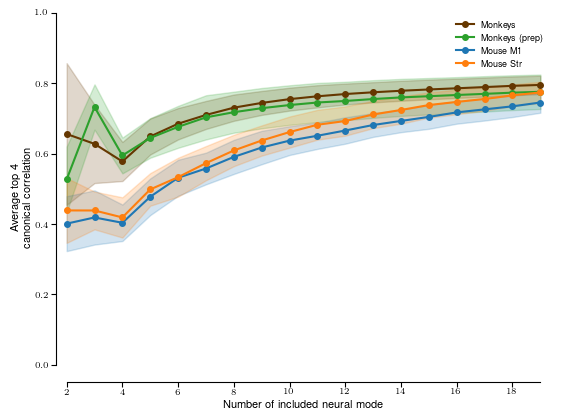

In [21]:
fig=plt.figure(dpi=100)
gs = fig.add_gridspec(nrows=1, ncols=1, wspace=0)
ax = fig.add_subplot(gs[0])

allDFs_M1, allDFs_Str = get_full_mouse_data()

plot_monkey_cca_dim(ax, full_list_MCx, allDFs_MCx)
plot_monkey_cca_dim_prep(ax, full_list_MCx, allDFs_MCx)
plot_mouse_cca_dim(ax, allDFs_M1)
plot_mouse_cca_dim(ax, allDFs_Str, 'Str')
ax.legend()

plt.savefig(FIGPATH / 'CCA-dim.pdf', format= 'pdf')
clear_output()

### Fig S2G: Procrustes

#### Align all sessions

In [22]:
defs = monkey_defs
pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))
print(f'{len(pairFileList1)=}')

side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

#align all data
allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.procrustes_wrapper(data1, data2))
allCCs0 = np.array(allCCs0).T


len(pairFileList1)=126
min_trials=15
min_time=15


#### Lower bound

In [23]:
single_FileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        single_FileList1.append((I,J))

n_iter = params.n_iter

#MCx
side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
side2df = [allDFs_MCx[j] for _,j in single_FileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
AllData1_ = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

warnings.filterwarnings("default")

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.procrustes_wrapper(data1, data2))
    inCCs0.append(r)
inCCs0 = np.array(inCCs0)
CC_lower_bound_MCx = np.percentile(inCCs0, 1, axis=1).T


#### Upper bound

In [24]:
single_FileList1 = []
for I, _ in enumerate(full_list_MCx):
    single_FileList1.append(I)


warnings.filterwarnings("ignore")
side1df = [allDFs_MCx[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)

warnings.filterwarnings("default")

n_iter = params.n_iter

n_shared_trial1 = AllData1.shape[2]
trialList1 = np.arange(n_shared_trial1)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.procrustes_wrapper(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_MCx = np.percentile(CCs1, 99, axis=1).T

#### Plot Procrustes correlations

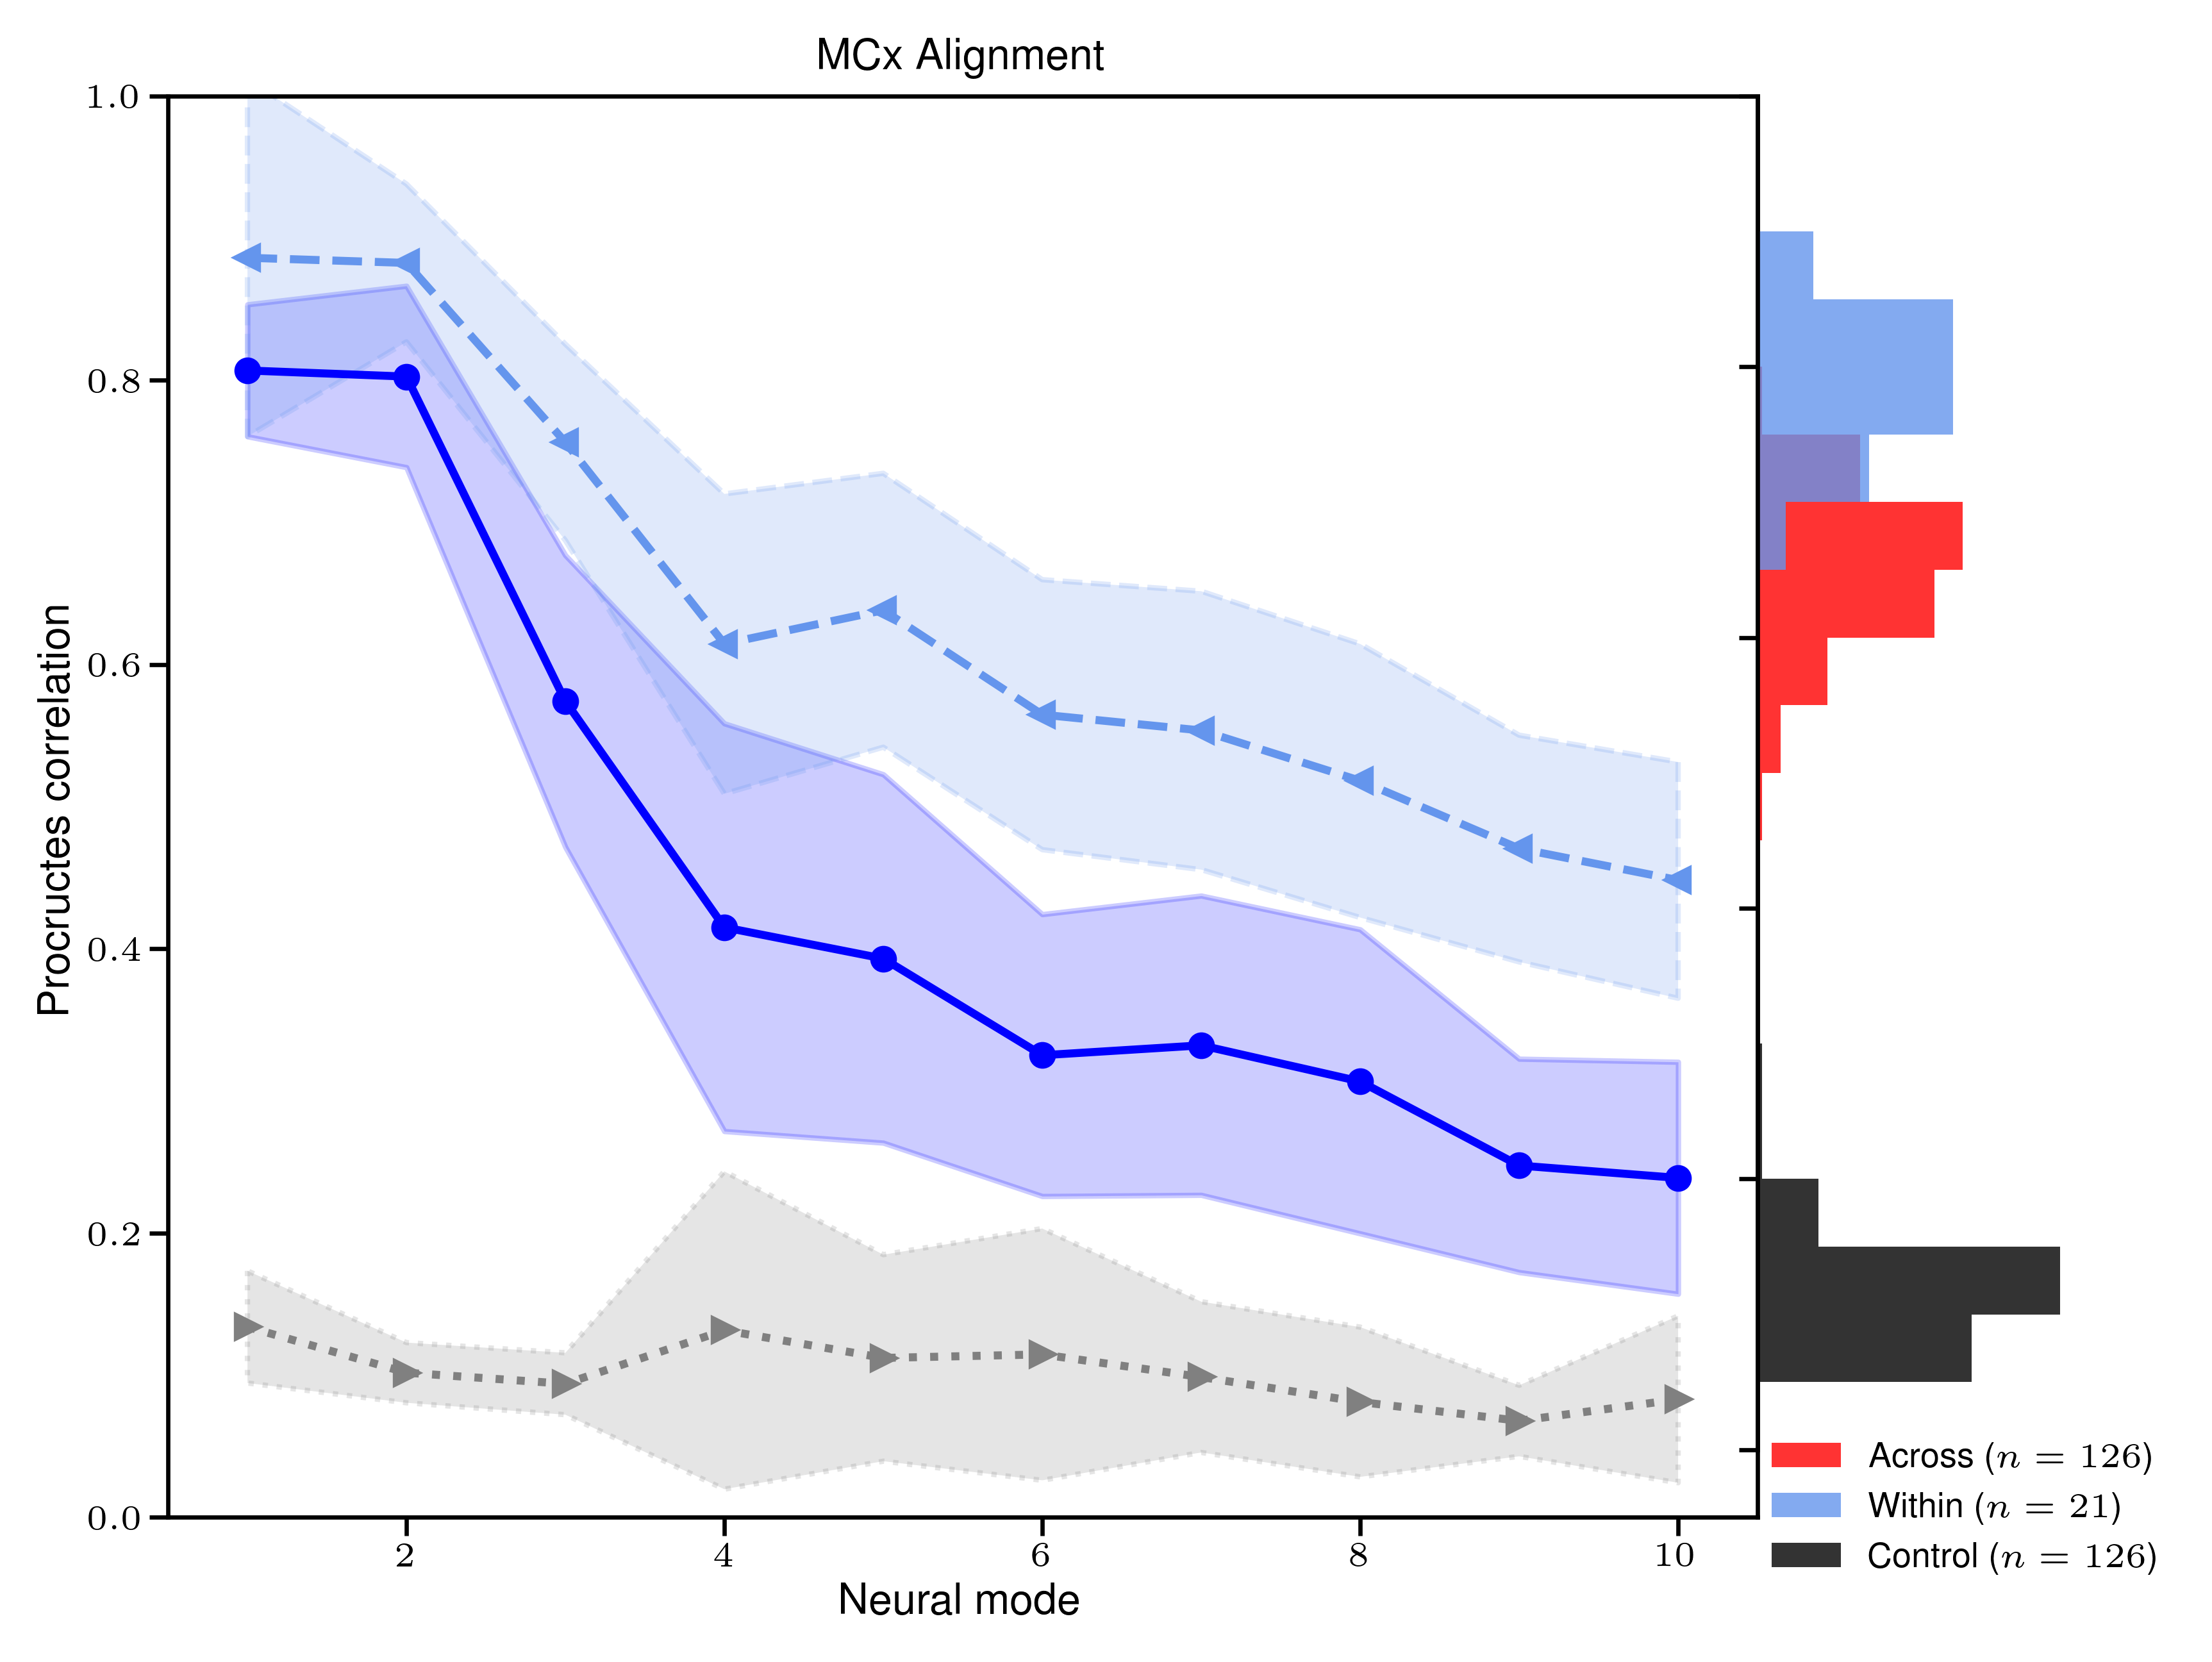

In [25]:
plt.close('all')
set_rc()
fig=plt.figure()
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

ax = fig.add_subplot(gs[0])
ax_hist = fig.add_subplot(gs[1])


utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), allCCs0, color='b', marker = 'o', label=f'Across, $n={allCCs0.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_upper_bound_MCx, color='cornflowerblue', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_MCx.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_lower_bound_MCx, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_MCx.shape[1]}$')

ax.set_ylim([0,1])
ax.set_xlim([.5,defs.n_components+.5])
ax.set_xlabel('Neural mode')
ax.set_title(f'{defs.areas[2]} Alignment')
ax.set_ylabel('Procructes correlation')


#plot the hist

bins = np.arange(0,1,0.05)
ax_hist.xaxis.set_visible(False)
ax_hist.set_facecolor('None')
ax_hist.spines['bottom'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['left'].set_bounds([0,1])
ax_hist.set_ylim([-.05,1])
ax_hist.hist(allCCs0[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs0.shape[1]}$)',
        color=params.colors.MainCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CC_upper_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CC_upper_bound_MCx.shape[1]}$)',
        color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
ax_hist.hist(CC_lower_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CC_lower_bound_MCx.shape[1]}$)',
        color=params.colors.LowerCC, alpha=.8, orientation='horizontal')

ax_hist.tick_params('y', direction='out')
ax_hist.set_yticklabels([])
ax_hist.legend(loc=(0,-.05))


fig.savefig(FIGPATH / 'monkey-procrustes-modes.pdf', format='pdf', bbox_inches='tight')

### Fig S2H: Procrustes vs CCA

len(pairFileList1)=126
min_trials=15
min_time=15


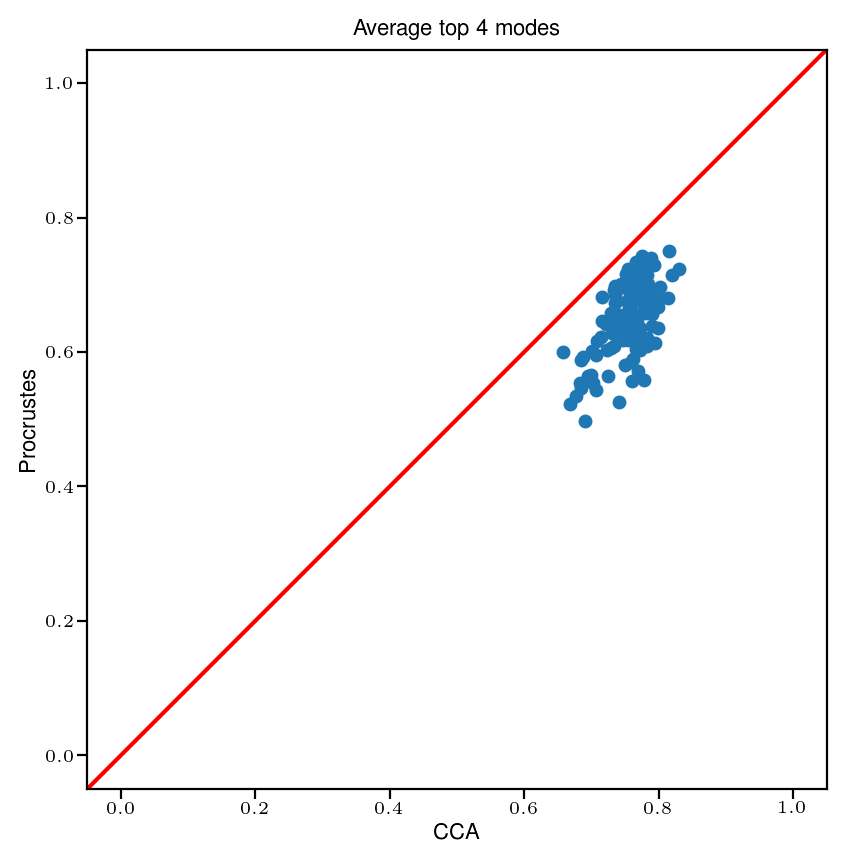

In [26]:
pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))
print(f'{len(pairFileList1)=}')

side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allPro=[]
allCC=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allPro.append(dt.procrustes_wrapper(data1, data2))
    allCC.append(dt.canoncorr(data1, data2))
allCC = np.array(allCC).T
allPro = np.array(allPro).T

# plot
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(allCC[:4,:].mean(axis=0), allPro[:4,:].mean(axis=0))
ax.axline([0, 0], [1, 1], color='r')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_ylim(min(xlim[0],ylim[0]), max(xlim[1], ylim[1]))
ax.set_aspect('equal')

ax.set_xlabel('CCA')
ax.set_ylabel('Procrustes')
ax.set_title('Average top 4 modes')
# ax.ticklabel_format(style='scientific', scilimits=(6,6), useMathText=True)

fig.savefig(FIGPATH / 'procrustes-CCA.pdf', format='pdf', bbox_inches='tight')